
# Tutorial for Human Pose Estimation


In[1]:



In [4]:
import yaml
import torch
import torch.nn as nn
from tqdm import tqdm
import os

## Dataset with MetaFi: 



Point cloud Pose reconstruction dataset collected by Ti 6843 mmWave radar. 40 subjects are included and the human poses are obtained by 2 RGB camera.
We provide cross-subject experiment settings with all daily activities. 
In the library, we provide a dataloader to use mmWave PC data, and predict these human poses. 



## Load the data



In[3]:



In [3]:
from pysensing.mmwave.PC.dataset.hpe import load_hpe_dataset
# The path contains the radHAR dataset
root =  '/home/junqiao/projects/data/MMFi_Dataset/'
train_dataset, test_dataset = load_hpe_dataset("MetaFi", root)

Using default config file.
using dataset: MetaFi DATA
S01 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S02 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S05 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S10 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S15 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S20 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S25 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S30 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S35 ['A02', 'A03', 'A04', 'A05', 'A13', 'A14', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A27']
S40 ['A02', 'A03', 

## Visualize the voxel image



(5, 150, 5) <class 'torch.Tensor'>


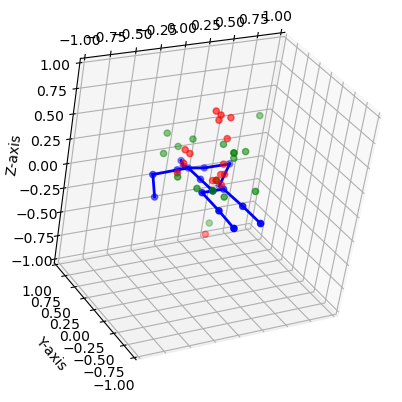

In [5]:
from matplotlib import pyplot as plt
from pysensing.mmwave.PC.tutorial.plot import plot_3d_graph
# Example of the samples in the dataset
index = 10  # Randomly select an index
pc,pose = train_dataset.__getitem__(index)
print(pc.shape, type(pose))
plot_3d_graph(pose, pc[0])

## Create model 



mmBody utilizes P4Transformer model as a baseline hpe method. From model.hpe, we can import 
desired hpe model designed for mmWave PC. The model parameter for P4transformer reimplemented 
for mmBody is as follows:



In[7]:



In [6]:
from pysensing.mmwave.PC.model.hpe import PointTransformerReg
model = PointTransformerReg(
                    input_dim = 5,
                    nblocks = 5,
                    n_p = 17
                )
print(model)

PointTransformerReg(
  (backbone): Backbone(
    (fc1): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (transformer1): TransformerBlock(
      (fc1): Linear(in_features=32, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=32, bias=True)
      (fc_delta): Sequential(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (fc_gamma): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (w_qs): Linear(in_features=128, out_features=128, bias=False)
      (w_ks): Linear(in_features=128, out_features=128, bias=False)
      (w_vs): Linear(in_features=128, out_features=128, bias=False)
    )
    (transition_downs): Modul

A shortcut for loading the hpe model to avoid the tedious hyper-parameter setting.



In[8]:



In [28]:
from pysensing.mmwave.PC.model.hpe import load_hpe_model
model = load_hpe_model("MetaFi", "PointTransformer")
print(model)

PointTransformerReg(
  (backbone): Backbone(
    (fc1): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (transformer1): TransformerBlock(
      (fc1): Linear(in_features=32, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=32, bias=True)
      (fc_delta): Sequential(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (fc_gamma): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (w_qs): Linear(in_features=128, out_features=128, bias=False)
      (w_ks): Linear(in_features=128, out_features=128, bias=False)
      (w_vs): Linear(in_features=128, out_features=128, bias=False)
    )
    (transition_downs): Modul

## Model Train



pysensing library support quick training of model with the following steps. The training interface 
incorporates pytorch loss functions, optimizers and dataloaders to facilate training. 
An example is provided for how to define the aforemetioned terms.



In[11]:



In [6]:
# Create pytorch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=16)

# Define pytorch loss function as criterion 
criterion = nn.CrossEntropyLoss()

# Define pytorch optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GPU acceleration with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A quick training using hpe_train. The resulted model parameters will be saved into "train_{num_epochs}.pth".



In[12]:



In [25]:
# Pysensing training interface
from pysensing.mmwave.PC.inference.hpe import hpe_train
# hpe_train(model, train_loader, num_epochs=1, optimizer=optimizer, criterion=criterion, device=device)

## Model inference



Load the pretrained model, e.g. from train_1.pth, and perform human action recognition!



In[13]:



In [29]:
# load pretrained model
from pysensing.mmwave.PC.inference import load_pretrain
model = load_pretrain(model, "MetaFi", "PointTransformer").to(device)
model.eval()


Use pretrained model!


PointTransformerReg(
  (backbone): Backbone(
    (fc1): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (transformer1): TransformerBlock(
      (fc1): Linear(in_features=32, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=32, bias=True)
      (fc_delta): Sequential(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (fc_gamma): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (w_qs): Linear(in_features=128, out_features=128, bias=False)
      (w_ks): Linear(in_features=128, out_features=128, bias=False)
      (w_vs): Linear(in_features=128, out_features=128, bias=False)
    )
    (transition_downs): Modul

Test the model on testing dataset.

In [30]:
from pysensing.mmwave.PC.inference.hpe import hpe_test
hpe_test(model, test_loader, criterion=criterion, device=device)

validation mpjpe:223.6264, loss:47.04039


Model inference on sample and deep feature embedding of input modality in HPE task.

In [13]:
# Model inference
idx = 5
points, pose= test_dataset.__getitem__(idx)
points = torch.tensor(points).unsqueeze(0).float().to(device)
predicted_result = model(points)
print("The predicted pose is {}, while the ground truth is {}".format(predicted_result.cpu(),pose))

# Deep feature embedding
from pysensing.mmwave.PC.inference.embedding import embedding
emb = embedding(input = points, model=model, dataset_name = "MetaFi", model_name = "PointTransformer", device=device)
print("The shape of feature embedding is: ", emb.shape)

The predicted pose is tensor([[[-0.0732, -0.0320,  2.8192],
         [-0.1610, -0.0239,  2.8217],
         [-0.1500,  0.3482,  2.8215],
         [-0.1503,  0.7307,  2.8390],
         [ 0.0712, -0.0892,  2.8306],
         [ 0.0469,  0.3171,  2.8479],
         [ 0.0531,  0.7271,  2.8484],
         [-0.0585, -0.3184,  2.8133],
         [-0.0409, -0.6009,  2.7986],
         [-0.0229, -0.7314,  2.7787],
         [-0.0215, -0.7764,  2.8044],
         [ 0.0928, -0.5512,  2.8026],
         [ 0.3014, -0.4980,  2.7939],
         [ 0.1892, -0.5354,  2.5988],
         [-0.1946, -0.5597,  2.8130],
         [-0.4262, -0.5528,  2.7339],
         [-0.2905, -0.5816,  2.5533]]], grad_fn=<ToCopyBackward0>), while the ground truth is tensor([[-8.5787e-02, -7.7896e-02,  3.0175e+00],
        [-1.9292e-01, -8.1096e-02,  3.0175e+00],
        [-1.7758e-01,  3.2295e-01,  3.0175e+00],
        [-1.7898e-01,  7.7592e-01,  3.0175e+00],
        [ 2.1350e-02, -7.4697e-02,  3.0175e+00],
        [ 1.6550e-02,  3.2295e-

## mmDiff: diffusion model for mmWave radar HPE

Load Diffusion Runner with model initialized. This process will define the setting for model and dataset. Currently two settings are implemented: 
1. "mmBody + P4Transformer": 
    Phase 1: Input [b, 4, 5000, 6]; Output: [b, 17, 3] and [b, 17, 64]. 
    Phase 2: GRC, LRC, TMC, SLC
2. "MetaFi + PointTransformer": 
    Phase 1: Input [b, 5, 150, 5]; Output: [b, 17, 3] and [b, 17, 32]. 
    Phase 2: GRC, TMC, SLC

In [14]:
from pysensing.mmwave.PC.model.hpe.mmDiff.load_mmDiff import load_mmDiff
mmDiffRunner = load_mmDiff("MetaFi")

Self.model_feat vadility passes.
MMdiff using PointTransformer as feature extractor.


Phase 1 Training: Can train phase 1 from scratch (is_train = True) or load pretrained phase 1 model (is_train = False). Set is_save = True to facilitate phase 2 training acceleration.
If phase 1 features are saved, set is_save = False.


In [15]:
mmDiffRunner.phase1_train(train_dataset, test_dataset, is_train=False, is_save=True)

Phase 1 use pretrained model!


Phase 1 can also receive self defined model and the model should follow the setting defined above. The Self-defined model should output coarse joints and coarse joint features

In [17]:
# Self defined model should output coarse joints and coarse joint features
from pysensing.mmwave.PC.model.hpe.pointTrans import PointTransformerReg_feat
model = PointTransformerReg_feat(
                    input_dim = 5,
                    nblocks = 5,
                    n_p = 17
                )
print(model)

mmDiffRunner.phase1_train(train_dataset, test_dataset, model_self=model, is_train=False, is_save=False)

PointTransformerReg_feat(
  (backbone): Backbone(
    (fc1): Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (transformer1): TransformerBlock(
      (fc1): Linear(in_features=32, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=32, bias=True)
      (fc_delta): Sequential(
        (0): Linear(in_features=3, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (fc_gamma): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
      )
      (w_qs): Linear(in_features=128, out_features=128, bias=False)
      (w_ks): Linear(in_features=128, out_features=128, bias=False)
      (w_vs): Linear(in_features=128, out_features=128, bias=False)
    )
    (transition_downs): 

Phase 2 Training: Can train from scratch (is_train = True) or load pretrained phase 2 model (is_train = False).

In [18]:
mmDiffRunner.phase2_train(train_loader = None, is_train = False)

Phase 2 use pretrained model!


Testing mmDiff

In [19]:
mmDiffRunner.test()

Testing...
Generating 133056 poses...
Generating 33264 poses...
===Action=== ==p#1 mm== =p#2 mm=
Test          38.36      37.62
Average       38.36      37.62
===Action=== ==p#1 mm== =p#2 mm=
Test          37.13      36.56
Average       37.13      36.56
(2/260) Data: 2.463453s | MPJPE:  37.1347 | P-MPJPE:  36.5630
===Action=== ==p#1 mm== =p#2 mm=
Test          42.57      40.07
Average       42.57      40.07
(3/260) Data: 3.847601s | MPJPE:  42.5711 | P-MPJPE:  40.0682
===Action=== ==p#1 mm== =p#2 mm=
Test          47.14      43.04
Average       47.14      43.04
(4/260) Data: 5.274641s | MPJPE:  47.1354 | P-MPJPE:  43.0379
===Action=== ==p#1 mm== =p#2 mm=
Test          51.08      45.50
Average       51.08      45.50
(5/260) Data: 6.747490s | MPJPE:  51.0834 | P-MPJPE:  45.5020
===Action=== ==p#1 mm== =p#2 mm=
Test          52.21      45.03
Average       52.21      45.03
(6/260) Data: 8.272478s | MPJPE:  52.2125 | P-MPJPE:  45.0301
===Action=== ==p#1 mm== =p#2 mm=
Test          53.30    

(67.39809258181123, 51.892936249416344)

## Dataset with mmBody

In [20]:
from pysensing.mmwave.PC.dataset.hpe import load_hpe_dataset
# The path contains the radHAR dataset
root =  '/home/junqiao/projects/data/mmpose/'
train_dataset, test_dataset = load_hpe_dataset("mmBody", root)

using dataset: mmBody DATA


torch.Size([4, 5184, 6]) <class 'torch.Tensor'>


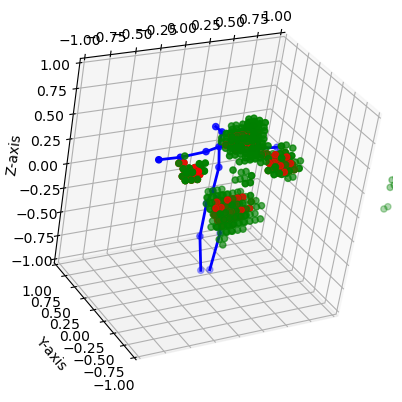

In [21]:
from matplotlib import pyplot as plt
from pysensing.mmwave.PC.tutorial.plot import plot_3d_graph
# Example of the samples in the dataset
index = 10  # Randomly select an index
pc,pose = train_dataset.__getitem__(index)
print(pc.shape, type(pose))
plot_3d_graph(pose, pc[0])

In [22]:
from pysensing.mmwave.PC.model.hpe import load_hpe_model
model = load_hpe_model("mmBody", "P4Transformer")
print(model)

P4Transformer(
  (tube_embedding): P4DConv(
    (conv_d): Sequential(
      (0): Conv2d(4, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_f): Sequential(
      (0): Conv2d(3, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): Sequential()
  )
  (pos_embedding): Conv1d(4, 1024, kernel_size=(1,), stride=(1,))
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_k): Linear(in_features=1024, out_features=2048, bias=False)
              (to_v): Linear(in_features=1024, out_features=2048, bias=False)
              (to_q): Linear(in_features=1024, out_features=2048, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=2048, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropou

In [23]:
# Create pytorch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=16, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=16)

# Define pytorch loss function as criterion 
criterion = nn.CrossEntropyLoss()

# Define pytorch optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GPU acceleration with cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
# load pretrained model
from pysensing.mmwave.PC.inference import load_pretrain
model = load_pretrain(model, "mmBody", "P4Transformer").to(device)
model.eval()


Use pretrained model!


P4Transformer(
  (tube_embedding): P4DConv(
    (conv_d): Sequential(
      (0): Conv2d(4, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_f): Sequential(
      (0): Conv2d(3, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (mlp): Sequential()
  )
  (pos_embedding): Conv1d(4, 1024, kernel_size=(1,), stride=(1,))
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_k): Linear(in_features=1024, out_features=2048, bias=False)
              (to_v): Linear(in_features=1024, out_features=2048, bias=False)
              (to_q): Linear(in_features=1024, out_features=2048, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=2048, out_features=1024, bias=True)
                (1): GELU(approximate='none')
                (2): Dropou

In [25]:
from pysensing.mmwave.PC.inference.hpe import hpe_test
# hpe_test(model, test_loader, criterion=criterion, device=device)

## mmDiff: diffusion model for mmWave radar HPE

In [26]:
from pysensing.mmwave.PC.model.hpe.mmDiff.load_mmDiff import load_mmDiff
mmDiffRunner = load_mmDiff("mmBody")

Self.model_feat vadility passes.
MMdiff using P4Transformer as feature extractor.


In [27]:
mmDiffRunner.phase1_train(train_dataset, test_dataset, is_train=False, is_save=True)

Phase 1 use pretrained model!


0.004061146462196378 0.07767320130147597
Saving Test.
(28109, 17, 3)
(28109, 17, 3)
(28109, 17, 64)
(28109, 5184, 6)


0.0018360977943928493 0.04909694526253224
Saving Train.
(39892, 17, 3)
(39892, 17, 3)
(39892, 17, 64)
(7979, 5184, 6)
(7979, 5184, 6)
(7979, 5184, 6)
(7979, 5184, 6)
(7976, 5184, 6)


In [28]:
mmDiffRunner.phase2_train(train_loader = None, is_train = False)

Phase 2 use pretrained model!


In [29]:
mmDiffRunner.test()

Testing...
Generating 39892 poses...
Generating 28109 poses...
===Action=== ==p#1 mm== =p#2 mm=
Test          47.86      30.63
Average       47.86      30.63
===Action=== ==p#1 mm== =p#2 mm=
Test          47.34      28.99
Average       47.34      28.99
(2/220) Data: 85.460025s | MPJPE:  47.3396 | P-MPJPE:  28.9870
===Action=== ==p#1 mm== =p#2 mm=
Test          52.92      34.35
Average       52.92      34.35
(3/220) Data: 128.533537s | MPJPE:  52.9226 | P-MPJPE:  34.3528
===Action=== ==p#1 mm== =p#2 mm=
Test          57.30      41.20
Average       57.30      41.20
(4/220) Data: 171.808520s | MPJPE:  57.3030 | P-MPJPE:  41.1966
===Action=== ==p#1 mm== =p#2 mm=
Test          57.92      42.85
Average       57.92      42.85
(5/220) Data: 215.282359s | MPJPE:  57.9161 | P-MPJPE:  42.8537
===Action=== ==p#1 mm== =p#2 mm=
Test          60.30      45.23
Average       60.30      45.23
(6/220) Data: 258.953604s | MPJPE:  60.3036 | P-MPJPE:  45.2285
===Action=== ==p#1 mm== =p#2 mm=
Test          6

(69.89549974051093, 55.062307693400044)